# Environment Setup

In [43]:
# standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [53]:
# other library imports
import sqlite3
import gspread
import scrapbook as sb

from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

from dateutil.relativedelta import relativedelta

In [45]:
# matplotlib customizations, as in class
plt.style.use("ggplot")
plt.tight_layout()
plt.rcParams["figure.figsize"] = [20, 20]

<Figure size 2000x2000 with 0 Axes>

# Loading the Data

In [47]:
# load the database and initialize a cursor
conn = sqlite3.connect('../data/data.db')
cursor = conn.cursor()

In [48]:
# get the data into a dataframe
cursor.execute("select * from ohlc_hw_cleaned")
df = pd.DataFrame(
    cursor.fetchall(),
    columns = [
        "ts", "open", "high",
        "low", "close", "adj_close",
        "volume", "ticker"
    ]
)
df.head()
conn.close()

,ts,open,high,low,close,adj_close,volume,ticker
0,1962-01-02 00:00:00,0.0,8.328744,8.272595,8.310028,1.079927,40740.0,HON
1,1962-01-03 00:00:00,0.0,8.403609,8.328744,8.403609,1.092089,83483.0,HON
2,1962-01-04 00:00:00,0.0,8.534623,8.422326,8.459758,1.099385,74801.0,HON
3,1962-01-05 00:00:00,0.0,8.534623,8.422326,8.441042,1.096953,42744.0,HON
4,1962-01-08 00:00:00,0.0,8.534623,8.347460,8.478474,1.101817,90830.0,HON


In [49]:
df.shape
df.info()

(953010, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953010 entries, 0 to 953009
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ts         953010 non-null  object 
 1   open       953010 non-null  float64
 2   high       953010 non-null  float64
 3   low        953010 non-null  float64
 4   close      953010 non-null  float64
 5   adj_close  953010 non-null  float64
 6   volume     953010 non-null  float64
 7   ticker     953010 non-null  object 
dtypes: float64(6), object(2)
memory usage: 58.2+ MB


## Filter as per Parameters

In [72]:
# parameter cell
# ticker = "UBER"
# months = 6

In [54]:
df["ts"] = pd.to_datetime(df["ts"])
upperBound, lowerBound = df["ts"].max(), df["ts"].max() - relativedelta(months = 6)
print(upperBound, lowerBound)

2023-12-08 00:00:00 2023-06-08 00:00:00


In [55]:
df.shape
df = df.loc[
    (df["ticker"] == ticker) &\
    (df["ts"] < upperBound) &\
    (df["ts"] >= lowerBound)
]
df.shape

(953010, 8)

(127, 8)

In [56]:
df.set_index("ts", inplace = True)
df.head()

,open,high,low,close,adj_close,volume,ticker
ts,,,,,,,
2023-06-08,39.180000,40.630001,39.040001,40.259998,40.259998,20301800.0,UBER
2023-06-09,40.049999,41.000000,40.020000,40.990002,40.990002,21932700.0,UBER
2023-06-12,41.259998,41.744999,41.060001,41.740002,41.740002,15987700.0,UBER
2023-06-13,41.750000,41.830002,40.889999,41.410000,41.410000,16659600.0,UBER
2023-06-14,41.299999,41.590000,40.570000,41.270000,38.744401,15077600.0,UBER


# Calculations Mentioned in HW2.md

In [58]:
# volatility estimation using function defined in class
def volatility(df, lookback = 10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

# daily return
def dailyReturn(df):
    return (df["close"] - df["open"]) / df["close"]

# max drawdown
def maxDrawdown(df):
    return (df["close"].cummax() - df["close"].cummin()) / df["close"].cummax()

In [62]:
df["volatility"] = volatility(df)
df["return"] = dailyReturn(df)
df["max_drawdown"] = maxDrawdown(df)
df.tail()

,open,high,low,close,adj_close,volume,ticker,volatility,return,max_drawdown
ts,,,,,,,,,,
2023-12-01,56.669998,57.865002,56.250000,57.349998,56.380001,28162400.0,UBER,0.241122,0.011857,0.297995
2023-12-04,60.009998,60.919998,58.570000,58.630001,58.630001,85417300.0,UBER,0.361480,-0.023537,0.313321
2023-12-05,58.009998,58.660000,57.701000,57.970001,57.970001,39170600.0,UBER,0.355537,-0.000690,0.313321
2023-12-06,58.369999,59.980000,58.360001,59.750000,57.970001,33835000.0,UBER,0.356267,0.023096,0.326192
2023-12-07,59.669998,60.994999,59.525002,60.980000,60.980000,34410200.0,UBER,0.355185,0.021482,0.339784


# Plotting

In [65]:
# plotting function from class
def series_plot(data, events=None, ax=None, title = None):
    data.plot(ax=ax)
    
    start_of_days = data.index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')
    if title is not None:
        ax.set_title(title)

In [66]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

Text(0.5, 0.98, 'Market action for UBER between 2023-06-08 00:00:00 and 2023-12-08 00:00:00')

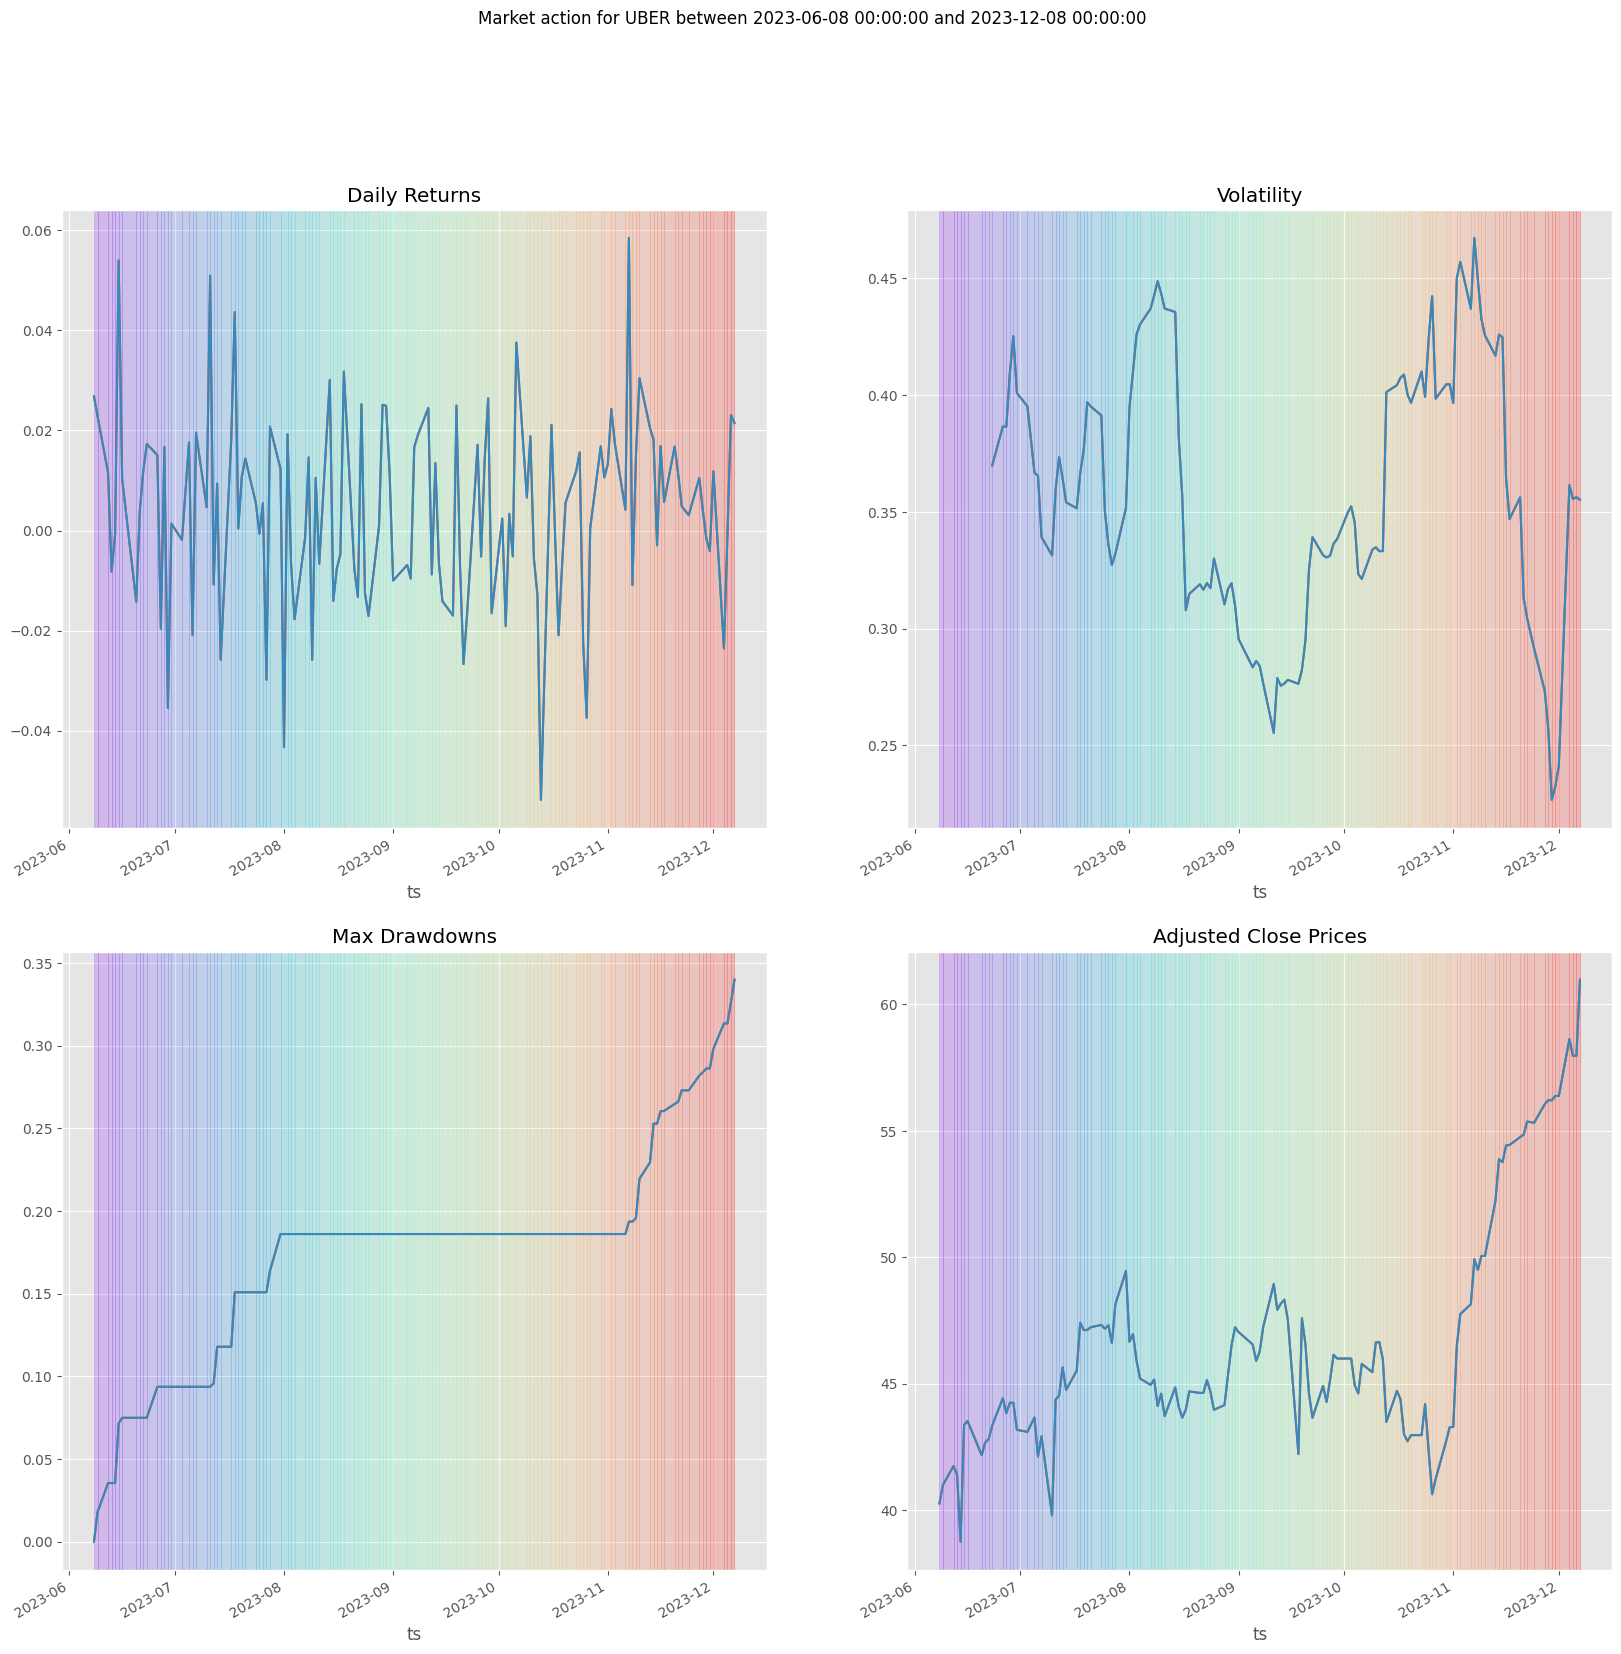

In [69]:
series_plot(df["return"], None, ax = ax[0, 0], title = "Daily Returns")
series_plot(df["volatility"], None, ax = ax[0, 1], title = "Volatility")
series_plot(df["max_drawdown"], None, ax = ax[1, 0], title = "Max Drawdowns")
series_plot(df["adj_close"], None, ax = ax[1, 1], title = "Adjusted Close Prices")
fig.suptitle("Market action for {} between {} and {}".format(ticker, lowerBound, upperBound))
fig

In [71]:
sb.glue('ticker', ticker)
sb.glue('from_date', str(lowerBound))
sb.glue('to_date', str(upperBound))
sb.glue('df', df, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=False)